Classification: Predict IsReturn for each invoice

Goal in Real Life Application: precision@K for targeted outreach and allocate resources efficiently.

The top 25% TotalLineValue for returns is $40, not huge values. Since even the “biggest” returns are just $40, missing some returns (false negatives) isn’t very costly. This goal will help result in more effective ROI.

Therefore, find high-value likely returners. By prioritizing precision, it'll minimize the number of false positives (customers who won't return their purchases). This ensures that your outreach efforts are targeted and effective, reducing unnecessary contact with customers and focus on capturing as many returners as possible with limitations to budgets/resources so precision is better. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import joblib
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, make_scorer, recall_score, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE #install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import shap
import optuna
from sklearn.metrics import precision_score
from sklearn.calibration import calibration_curve

In [2]:
df = pd.read_csv('online_retail_cleaned.csv')
df.IsReturn.value_counts()

IsReturn
0    789533
1     16087
Name: count, dtype: int64

In [3]:
df = pd.get_dummies(df, columns=['InvoiceHour'], prefix='InvoiceHour_')
df = pd.get_dummies(df, columns=['InvoiceMonth'], prefix='InvoiceMonth_')

# Define target variable
y = df['IsReturn']

# Drop columns that should not be used as features
X = df.drop(columns=['Customer ID','IsReturn', 'Invoice', 'InvoiceDate', 'StockCode','Description',"Country"]) 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # Ensures class ratio consistency
    random_state=42
)

In [10]:
def main(id, X_train, y_train, scale_pos_weight_value):
    return execute_model(id, X_train, y_train, scale_pos_weight_value)
    

# Top 5% Precision
def precision_at_k(y_test, y_pred_custom, k_percent=0.05):
    df_preds = pd.DataFrame({
        'proba': y_pred_custom,         # predicted probabilities for class 1
        'actual': y_test               # true labels (0 or 1)
    })

    # Sort by predicted probability descending (most return-like first)
    df_preds = df_preds.sort_values(by='proba', ascending=False).reset_index(drop=True)

    # Define Top-K% (e.g., top 5%)
    K = int(len(df_preds) * k_percent)

    # Slice top K rows
    top_k = df_preds.iloc[:K]

    # Calculate Top-K Precision
    precision_at_k = top_k['actual'].sum() / K
    print(f"Top-{k_percent*100:.0f}% Precision: {precision_at_k:.4f}")
    return df_preds


def execute_model(id, X_train, y_train, scale_pos_weight_value):
    xgb_model = XGBClassifier(
        scale_pos_weight=scale_pos_weight_value,
        eval_metric='logloss',
        random_state=42
    )

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
    print("AUC-PR:", average_precision_score(y_test, y_pred_proba))
    df_preds = precision_at_k(y_test, y_pred_proba, k_percent=0.05)

    """
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()
    """

    # Save the model
    joblib.dump(xgb_model, f"model_{id}.pkl")
    
    return xgb_model

In [6]:
# weight ratio between the majority class (non-returns) and the minority class (returns) in the training data.
scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale_pos_weight_value:.2f}")

scale_pos_weight: 49.08


The scale_pos_weight parameter tells XGBoost to penalize the majority class less and the minority class more, so the model takes returns (IsReturn == 1) more seriously.

Each return is treated as 49 times more important than a non-return.

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    157907
           1       0.08      0.78      0.14      3217

    accuracy                           0.81    161124
   macro avg       0.54      0.79      0.52    161124
weighted avg       0.98      0.81      0.88    161124

AUC-ROC: 0.8890574727687964
AUC-PR: 0.24557620642799188
Top-5% Precision: 0.1822


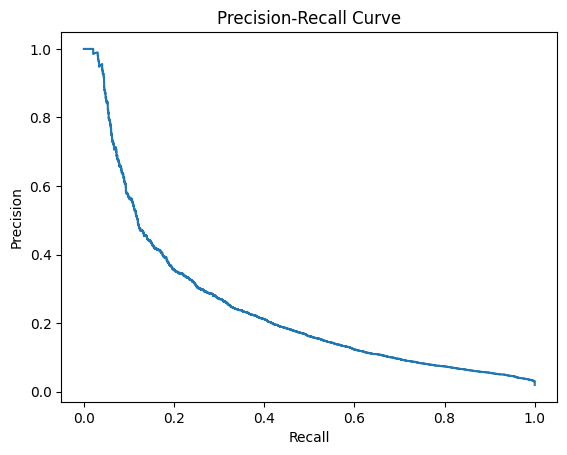

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [7]:
main(1, X_train, y_train, scale_pos_weight_value)

Try with SMOTE and scale_pos_weight

In [11]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

main(2, X_train_smote, y_train_smote, scale_pos_weight_value)

              precision    recall  f1-score   support

           0       1.00      0.65      0.78    157907
           1       0.05      0.90      0.09      3217

    accuracy                           0.65    161124
   macro avg       0.52      0.77      0.44    161124
weighted avg       0.98      0.65      0.77    161124

AUC-ROC: 0.8746024038076468
AUC-PR: 0.21612140849237715
Top-5% Precision: 0.1692


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Try undersampling

In [ ]:
undersampler = RandomUnderSampler(
        sampling_strategy='auto',
        random_state=42
    )

X_under, y_under = undersampler.fit_resample(X_train, y_train)

main(3, X_under, y_under, scale_pos_weight_value)

              precision    recall  f1-score   support

           0       1.00      0.46      0.63    157907
           1       0.04      0.98      0.07      3217

    accuracy                           0.47    161124
   macro avg       0.52      0.72      0.35    161124
weighted avg       0.98      0.47      0.62    161124

AUC-ROC: 0.8795022415729256
AUC-PR: 0.18578097984776426
Top-5% Precision: 0.1672


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Undersampling helped recall (1) but not precision.

SMOTE + undersampling

In [ ]:
smote = SMOTE(sampling_strategy=0.5, random_state=42) 
X_train_smote, y_train_smote= smote.fit_resample(X_train, y_train)

undersampler = RandomUnderSampler(
        sampling_strategy='auto',
        random_state=42
    )

X_final, y_final = undersampler.fit_resample(X_train_smote, y_train_smote)
main(4, X_final, y_final, scale_pos_weight_value)

              precision    recall  f1-score   support

           0       1.00      0.61      0.76    157907
           1       0.05      0.93      0.09      3217

    accuracy                           0.62    161124
   macro avg       0.52      0.77      0.42    161124
weighted avg       0.98      0.62      0.74    161124

AUC-ROC: 0.8804427187312512
AUC-PR: 0.21324235637416103
Top-5% Precision: 0.1692


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

SMOTE helped increase precision as compared to just with undersampling.

#### Feature Importance using Model 1

Model 1 gives the best precision and precision@5%.

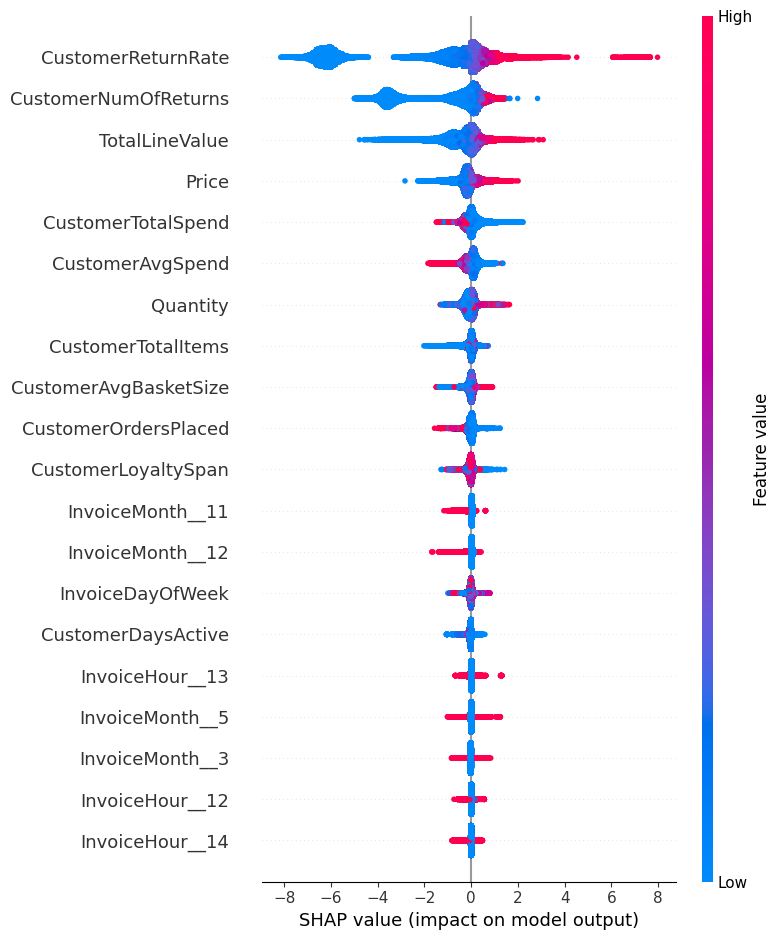

In [38]:
model = joblib.load("model_1.pkl")

explainer = shap.Explainer(model)
shap_values = explainer(X_train)
# Summary plot - shows top features across the entire dataset
shap.summary_plot(shap_values, X_train)

A SHAP value shows how much a feature pushes a prediction higher or lower (toward predicting a return or not).
- Values to the right (positive) increase the model’s predicted probability of a return.
- Values to the left (negative) lower the probability of a return.

CustomerReturnRate is the most important feature.
- high return rate = strongly increase return prediction.

CustomerNumOfReturns
- high values = high return prediction
- past returners are more likely to return again.

TotalLineValue & Price
- higher priced items = higher chance of return

CustomerTotalSpend
- lower total spend = higher return prediction
- higher-value customers are less likely to return

InvoiceMonth_11 and _12
- nov and dec are associated with lower return likelihood

CustomerLoyaltySpan / OrdersPlaced / DaysActive
- Longer relationship = less likely to return

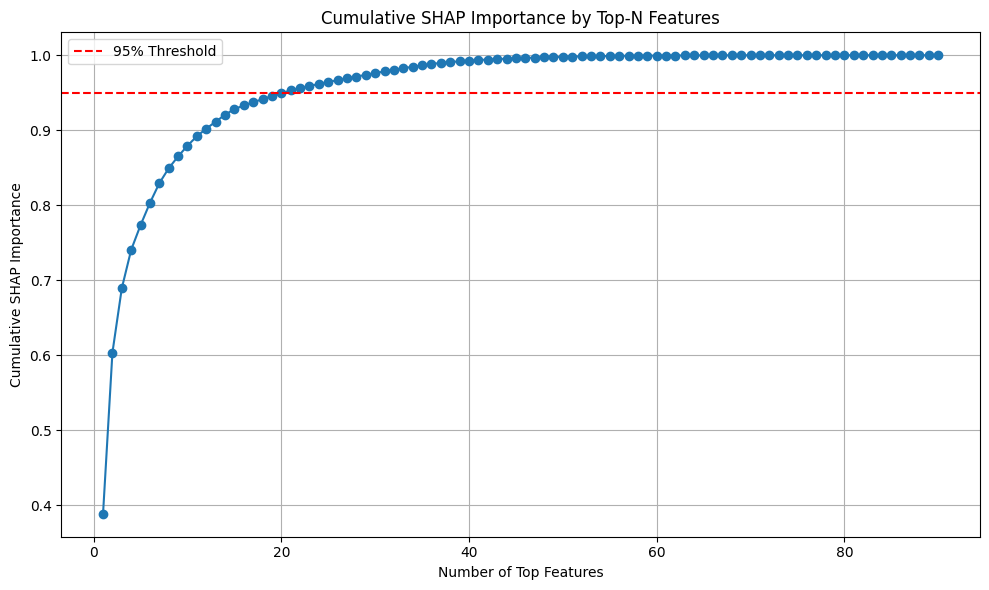

In [39]:
# After computing SHAP values
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
sorted_shap = np.sort(mean_abs_shap)[::-1]
cumulative = np.cumsum(sorted_shap) / np.sum(sorted_shap)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative)+1), cumulative, marker='o')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')
plt.title("Cumulative SHAP Importance by Top-N Features")
plt.xlabel("Number of Top Features")
plt.ylabel("Cumulative SHAP Importance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
# Find the cutoff where 95% of SHAP importance is reached
num_features = np.argmax(cumulative >= 0.95) + 1
print(f"Top {num_features} features capture 95% of SHAP importance")

Top 21 features capture 95% of SHAP importance


In [45]:
def shap_reduce(id, num_features):
    shap_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'MeanAbsSHAP': mean_abs_shap
    }).sort_values(by='MeanAbsSHAP', ascending=False)

    # Get top features
    top_features = shap_importance.head(num_features)['Feature'].tolist()
    print(top_features)

    # Filter training and test sets to top SHAP features
    X_train_reduced = X_train[top_features]
    X_test_reduced = X_test[top_features]

    # Retrain
    xgb_reduced = XGBClassifier(scale_pos_weight=scale_pos_weight_value,
                                eval_metric='logloss',
                                random_state=42)
    xgb_reduced.fit(X_train_reduced, y_train)

    y_pred = xgb_reduced.predict(X_test_reduced)
    y_pred_proba = xgb_reduced.predict_proba(X_test_reduced)[:, 1]

    print(classification_report(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))
    print("AUC-PR:", average_precision_score(y_test, y_pred_proba))

    df_preds = precision_at_k(y_test, y_pred_proba, k_percent=0.05)
    
    joblib.dump((xgb_reduced, top_features), f"model_{id}.pkl")

In [52]:
shap_reduce(5, 21)

['CustomerReturnRate', 'CustomerNumOfReturns', 'TotalLineValue', 'Price', 'CustomerTotalSpend', 'CustomerAvgSpend', 'Quantity', 'CustomerTotalItems', 'CustomerAvgBasketSize', 'CustomerOrdersPlaced', 'CustomerLoyaltySpan', 'InvoiceMonth__11', 'InvoiceMonth__12', 'InvoiceDayOfWeek', 'CustomerDaysActive', 'InvoiceHour__13', 'InvoiceMonth__5', 'InvoiceMonth__3', 'InvoiceHour__12', 'InvoiceHour__14', 'InvoiceMonth__1']
              precision    recall  f1-score   support

           0       0.99      0.80      0.89    157907
           1       0.08      0.78      0.14      3217

    accuracy                           0.80    161124
   macro avg       0.53      0.79      0.51    161124
weighted avg       0.98      0.80      0.87    161124

AUC-ROC: 0.8867044215570483
AUC-PR: 0.23958401972256
Top-5% Precision: 0.1783


Recall (1) and Precision (1) are the same as Model 1 but Precision@5% and AUC-PR a bit worse (~0.01)

In [51]:
# Find the cutoff where 94% of SHAP importance is reached
num_features = np.argmax(cumulative >= 0.94) + 1
print(f"Top {num_features} features capture 94% of SHAP importance")

Top 18 features capture 94% of SHAP importance


In [53]:
shap_reduce(6, 18)

['CustomerReturnRate', 'CustomerNumOfReturns', 'TotalLineValue', 'Price', 'CustomerTotalSpend', 'CustomerAvgSpend', 'Quantity', 'CustomerTotalItems', 'CustomerAvgBasketSize', 'CustomerOrdersPlaced', 'CustomerLoyaltySpan', 'InvoiceMonth__11', 'InvoiceMonth__12', 'InvoiceDayOfWeek', 'CustomerDaysActive', 'InvoiceHour__13', 'InvoiceMonth__5', 'InvoiceMonth__3']
              precision    recall  f1-score   support

           0       0.99      0.80      0.89    157907
           1       0.08      0.79      0.14      3217

    accuracy                           0.80    161124
   macro avg       0.53      0.79      0.51    161124
weighted avg       0.98      0.80      0.87    161124

AUC-ROC: 0.8868610466839691
AUC-PR: 0.23900000526486684
Top-5% Precision: 0.1775


In [56]:
# Find the cutoff where 93% of SHAP importance is reached
num_features = np.argmax(cumulative >= 0.93) + 1
print(f"Top {num_features} features capture 93% of SHAP importance")

Top 16 features capture 93% of SHAP importance


In [55]:
shap_reduce(7, 16)

['CustomerReturnRate', 'CustomerNumOfReturns', 'TotalLineValue', 'Price', 'CustomerTotalSpend', 'CustomerAvgSpend', 'Quantity', 'CustomerTotalItems', 'CustomerAvgBasketSize', 'CustomerOrdersPlaced', 'CustomerLoyaltySpan', 'InvoiceMonth__11', 'InvoiceMonth__12', 'InvoiceDayOfWeek', 'CustomerDaysActive', 'InvoiceHour__13']
              precision    recall  f1-score   support

           0       0.99      0.80      0.89    157907
           1       0.07      0.78      0.14      3217

    accuracy                           0.80    161124
   macro avg       0.53      0.79      0.51    161124
weighted avg       0.98      0.80      0.87    161124

AUC-ROC: 0.8844180295552118
AUC-PR: 0.231576724453997
Top-5% Precision: 0.1742


Model 5 or 6 have less features and the next best precision scores. Model 5 is slightly better but will evaluate shap to see whether the features are strong.

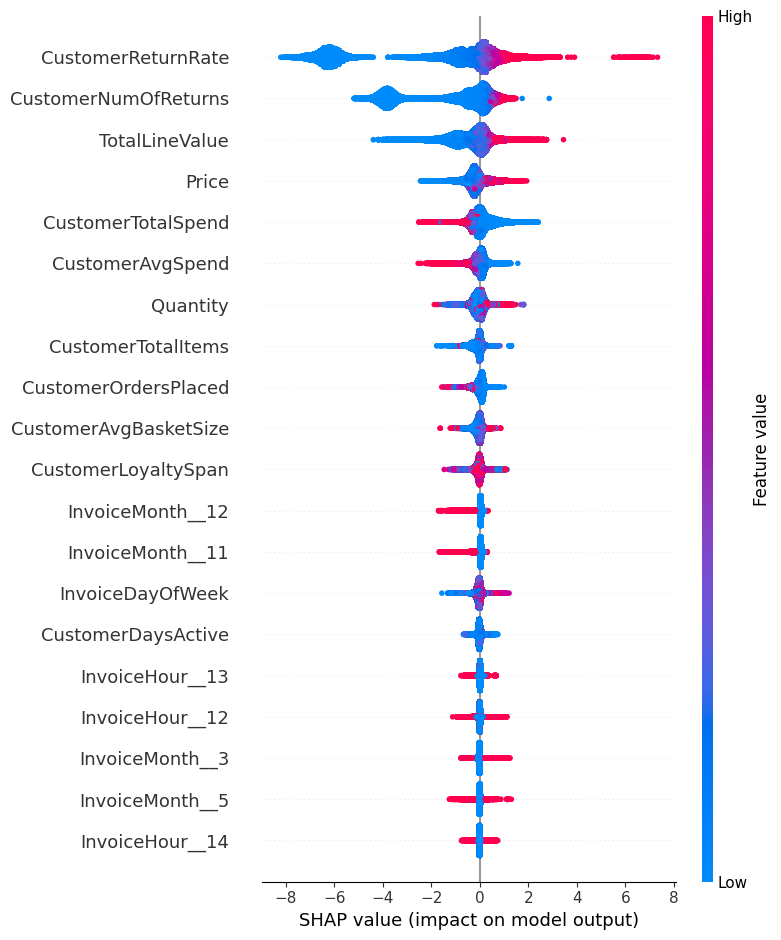

In [58]:
model, top_features = joblib.load("model_5.pkl")
X_train_reduced = X_train[top_features]

explainer = shap.Explainer(model)
shap_values = explainer(X_train_reduced)
# Summary plot - shows top features across the entire dataset
shap.summary_plot(shap_values, X_train_reduced)

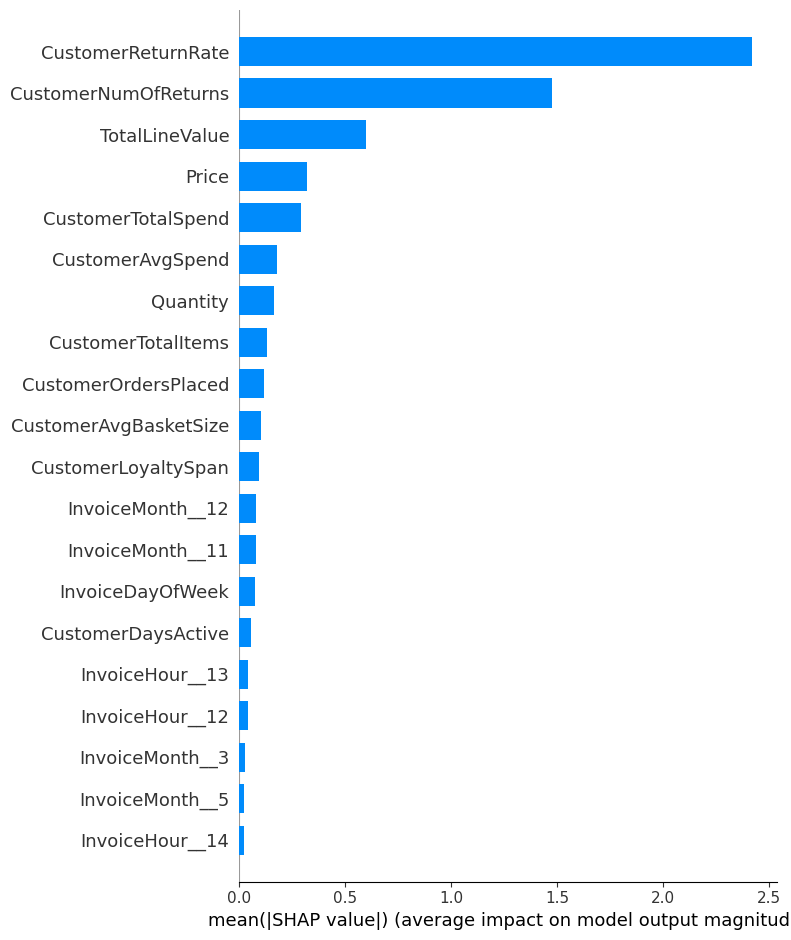

In [59]:
shap.summary_plot(shap_values, X_train_reduced, plot_type="bar")

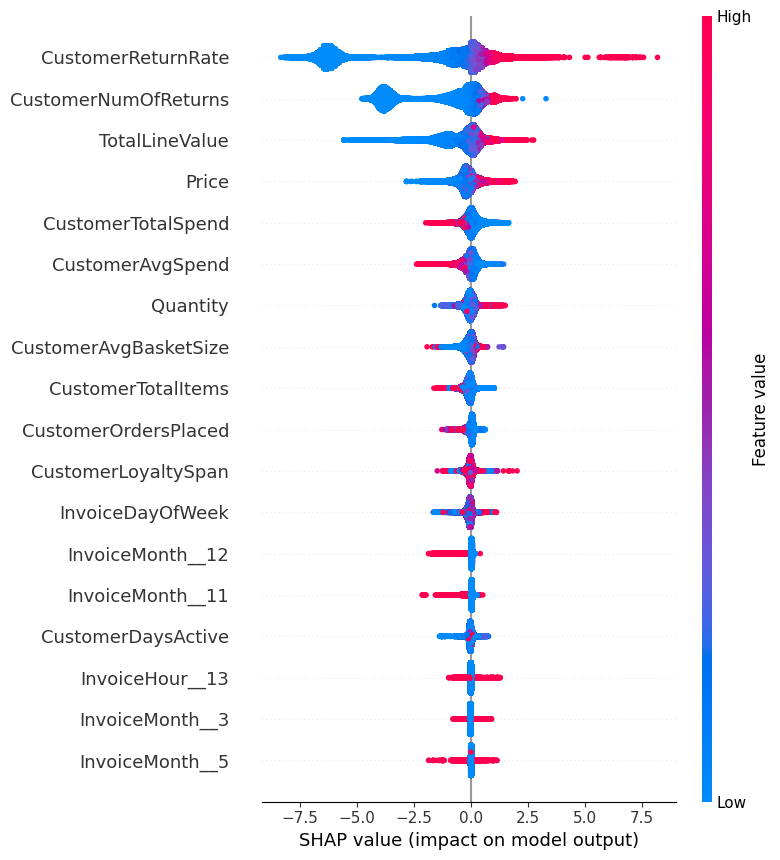

In [60]:
model, top_features = joblib.load("model_6.pkl")
X_train_reduced = X_train[top_features]

explainer = shap.Explainer(model)
shap_values = explainer(X_train_reduced)
# Summary plot - shows top features across the entire dataset
shap.summary_plot(shap_values, X_train_reduced)

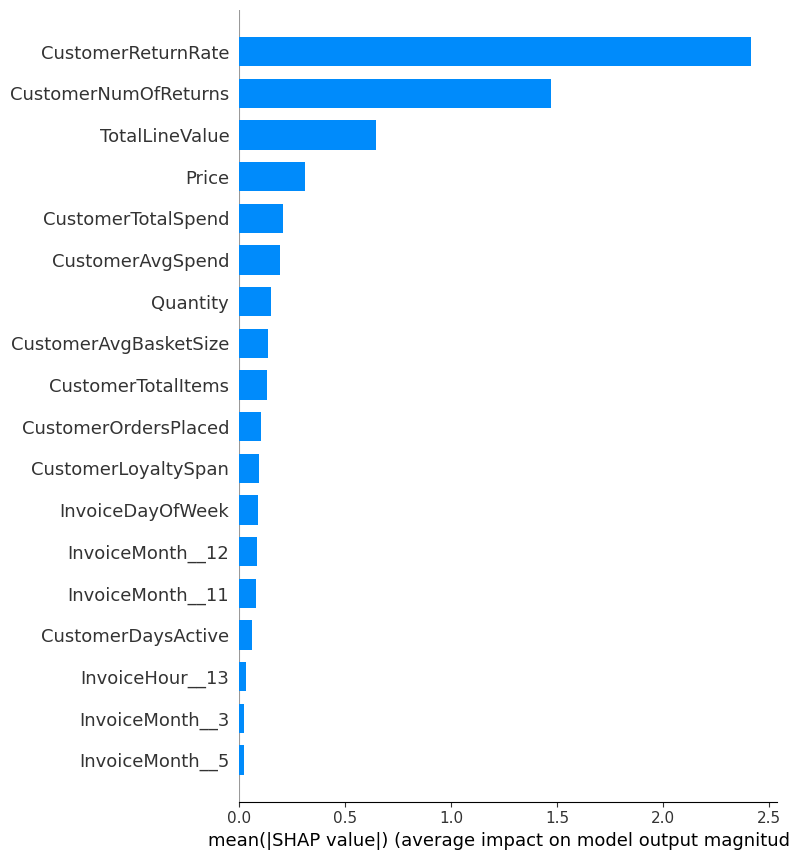

In [61]:
shap.summary_plot(shap_values, X_train_reduced, plot_type="bar")

#### Hyperparameter tuning using Model 6

Model 6 has the least amount of features but kept very similar precision scores as Model 5 and Model 1.

In [66]:
xgb_model, top_features = joblib.load("model_6.pkl")
X_train_top_features = X_train[top_features]
X_test_top_features = X_test[top_features]

Random Search CV

In [ ]:
# Define hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='average_precision',
    cv=skf,  # use stratified folds
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run the search
random_search.fit(X_train_top_features, y_train)

# Output best parameters
print("Best parameters found:", random_search.best_params_)
print("Best AUC-PR score:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, subsample=0.8; total time=  12.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, subsample=0.8; total time=  12.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, subsample=0.8; total time=  13.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=200, subsample=1.0; total time=  13.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, subsample=0.8; total time=  13.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, subsample=0.8; total time=  13.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, 

In [77]:
# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

y_pred_proba = random_search.best_estimator_.predict_proba(X_test_top_features)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("Test AUC-ROC:", roc_auc_score(y_test, y_pred_proba))
print("Test AUC-PR:", average_precision_score(y_test, y_pred_proba))
df_preds = precision_at_k(y_test, y_pred_proba, k_percent=0.05)

joblib.dump((random_search.best_estimator_, top_features), "model_8.pkl")

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    157907
           1       0.09      0.69      0.16      3217

    accuracy                           0.85    161124
   macro avg       0.54      0.77      0.54    161124
weighted avg       0.97      0.85      0.90    161124

Test AUC-ROC: 0.8816493149992539
Test AUC-PR: 0.25889436542089783
Top-5% Precision: 0.1819


['model_8.pkl']

Optuna

In [74]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.4),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 8),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 30, 70)
    }

    model = XGBClassifier(**params, eval_metric="logloss")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, 
        X_train_top_features, 
        y_train, 
        cv=skf, 
        scoring='average_precision',
        n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best AUC-PR:", study.best_value)

[I 2025-03-25 21:47:12,726] A new study created in memory with name: no-name-dd53411e-5a2b-4f4e-9644-dc5e4083e183
[I 2025-03-25 21:47:30,075] Trial 0 finished with value: 0.22895460040868815 and parameters: {'n_estimators': 468, 'max_depth': 5, 'learning_rate': 0.1654909457151886, 'subsample': 0.9244946127968643, 'colsample_bytree': 0.626714270609545, 'gamma': 0.08376274229485947, 'min_child_weight': 8, 'scale_pos_weight': 57}. Best is trial 0 with value: 0.22895460040868815.
[I 2025-03-25 21:47:46,988] Trial 1 finished with value: 0.23763217955600063 and parameters: {'n_estimators': 335, 'max_depth': 7, 'learning_rate': 0.07492848815224629, 'subsample': 0.6070939880893776, 'colsample_bytree': 0.7455918370751448, 'gamma': 0.30161890378863415, 'min_child_weight': 1, 'scale_pos_weight': 47}. Best is trial 1 with value: 0.23763217955600063.
[I 2025-03-25 21:48:04,489] Trial 2 finished with value: 0.2570369923286678 and parameters: {'n_estimators': 374, 'max_depth': 8, 'learning_rate': 0.0

Best Parameters: {'n_estimators': 258, 'max_depth': 9, 'learning_rate': 0.12563156706061632, 'subsample': 0.9185456468239643, 'colsample_bytree': 0.9316520311385714, 'gamma': 0.1275553685879767, 'min_child_weight': 3, 'scale_pos_weight': 38}
Best AUC-PR: 0.2621317106603035


In [76]:
best_params = study.best_params
best_params.update({
    'eval_metric': 'logloss',
    'random_state': 42
})

# retrain on the full training data
best_model = XGBClassifier(**best_params)
best_model.fit(X_train_top_features, y_train)

# predict on test set
y_pred_proba = best_model.predict_proba(X_test_top_features)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# evaluate
print(classification_report(y_test, y_pred))
print("Test AUC-ROC:", roc_auc_score(y_test, y_pred_proba))
print("Test AUC-PR:", average_precision_score(y_test, y_pred_proba))
df_preds = precision_at_k(y_test, y_pred_proba, k_percent=0.05)

joblib.dump((best_model, top_features), "model_9.pkl")

              precision    recall  f1-score   support

           0       0.99      0.91      0.95    157907
           1       0.12      0.61      0.20      3217

    accuracy                           0.90    161124
   macro avg       0.55      0.76      0.57    161124
weighted avg       0.97      0.90      0.93    161124

Test AUC-ROC: 0.8853462396629626
Test AUC-PR: 0.27231125595323025
Top-5% Precision: 0.1853


['model_9.pkl']

These hyperparameters are focused on:
- Deep trees → capture complex patterns
- Slightly aggressive learning
- High class weighting → favors high-precision positive predictions
- Generalization-friendly subsampling



In [83]:
def evaluate_model_ranking(y_test, y_pred, top_k_percents=[0.01, 0.02, 0.03, 0.05, 0.10, 0.20], n_bins=10):
    """
    Evaluate model precision at top K% and calibration.

    Parameters:
    - y_true: array-like, true binary labels (0 or 1)
    - y_pred_probs: array-like, predicted probabilities (from your model)
    - top_k_percents: list of thresholds for top-K% precision (e.g. [0.01, 0.05])
    - n_bins: number of bins for calibration curve

    Returns:
    - DataFrame of precision@k
    - Calibration curve plot
    """

    df = pd.DataFrame({"true": y_test, "score": y_pred})
    df = df.sort_values("score", ascending=False).reset_index(drop=True)

    precision_at_k = []
    for k in top_k_percents:
        top_k = int(k * len(df))
        preds_top_k = np.ones(top_k)  # Predict all top-k as returners
        actuals_top_k = df["true"].values[:top_k]
        precision = precision_score(actuals_top_k, preds_top_k)
        precision_at_k.append({
            "Threshold": f"Top {int(k * 100)}%",
            "Precision": round(precision, 4)
        })

    precision_df = pd.DataFrame(precision_at_k)

    # Plot calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=n_bins)

    plt.figure(figsize=(6, 5))
    plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Actual Return Rate')
    plt.title('Calibration Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return precision_df


In [ ]:
# Save X (features)
X_train_top_features.to_csv("X_train_selected.csv", index=False)
X_test_top_features.to_csv("X_test_selected.csv", index=False)

# Save y (target)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

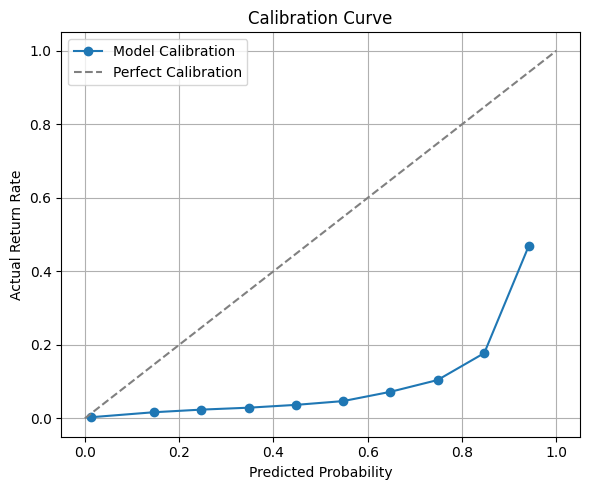

,Threshold,Precision
0,Top 1%,0.4314
1,Top 2%,0.3097
2,Top 3%,0.2475
3,Top 5%,0.1853
4,Top 10%,0.1207
5,Top 20%,0.0764


In [ ]:
model, top_features = joblib.load("model_9.pkl")

y_pred = model.predict(X_test_top_features)
y_pred_proba = model.predict_proba(X_test_top_features)[:, 1]

precision_df = evaluate_model_ranking(y_test, y_pred_proba)
precision_df

#### Benchmark with logistic regression

In [87]:
# Automatically exclude one-hot encoded features (based on prefix)
exclude = [col for col in X_train_top_features.columns if col.startswith('InvoiceMonth_') or 
                                             col.startswith('InvoiceHour_')] 

# Features to scale = everything else
features_to_scale = [col for col in X_train_top_features.columns if col not in exclude]

In [ ]:
X_train_features_to_scale = X_train_top_features[features_to_scale]
X_test_features_to_scale = X_test_top_features[features_to_scale]

# Fit scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features_to_scale)

# Apply same scaler to test data
X_test_scaled = scaler.transform(X_test_features_to_scale)

# Convert scaled features back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features_to_scale, index=X_train_features_to_scale.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features_to_scale, index=X_test_features_to_scale.index)

# Keep the excluded columns as-is
X_train_excluded = X_train_top_features[exclude]
X_test_excluded = X_test_top_features[exclude]

# Recombine scaled and excluded features
X_train_final = pd.concat([X_train_scaled_df, X_train_excluded], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test_excluded], axis=1)

In [91]:
# Logistic Regression with balanced class weight for fairness
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_model.fit(X_train_final, y_train)

# Predict using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_log = cross_val_predict(log_model, X_test_final, y_test, cv=cv)
y_proba_log = cross_val_predict(log_model, X_test_final, y_test, cv=cv, method='predict_proba')[:, 1]

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))
roc_auc_log = roc_auc_score(y_test, y_proba_log)
print("AUC-ROC:", roc_auc_log)
print("AUC-PR:", average_precision_score(y_test, y_pred_log))
df_preds = precision_at_k(y_test, y_pred_log, k_percent=0.05)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91    157907
           1       0.08      0.67      0.14      3217

    accuracy                           0.84    161124
   macro avg       0.54      0.76      0.53    161124
weighted avg       0.97      0.84      0.90    161124

AUC-ROC: 0.8582822244448827
AUC-PR: 0.06045135212567124
Top-5% Precision: 0.0827


In [92]:
log_cv = LogisticRegressionCV(
    Cs=10,  # Try 10 values from small to large
    cv=5,
    scoring='average_precision', 
    class_weight='balanced',
    penalty='l2',  # Ridge regularization
    solver='liblinear',
    max_iter=1000,
    random_state=42
)
log_cv.fit(X_train_final, y_train)

# Predict using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_log = cross_val_predict(log_cv, X_test_final, y_test, cv=cv)
y_proba_log = cross_val_predict(log_cv, X_test_final, y_test, cv=cv, method='predict_proba')[:, 1]

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))
roc_auc_log = roc_auc_score(y_test, y_proba_log)
print("AUC-ROC:", roc_auc_log)
print("AUC-PR:", average_precision_score(y_test, y_pred_log))
df_preds = precision_at_k(y_test, y_pred_log, k_percent=0.05)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91    157907
           1       0.08      0.65      0.14      3217

    accuracy                           0.84    161124
   macro avg       0.54      0.75      0.53    161124
weighted avg       0.97      0.84      0.90    161124

AUC-ROC: 0.8558543248343614
AUC-PR: 0.058601223276593326
Top-5% Precision: 0.0780
